<h1><center>Práctica Donativos Veterano de Guerra<center><h1>


# Integrantes

Sofía Maceín Sanz, María Araceli Pérez Buendía.

*Fecha de entrega: 23 de febrero de 2024*

# 0. Librerias

In [1]:
# Paquetes y librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

%matplotlib inline     
sns.set(color_codes=True)

Tambien hará falta descargarse, en caso de no tenerlos los paquetes:

In [2]:
#pip install imblearn

In [3]:
import warnings

# Ignorar todas las advertencias
warnings.filterwarnings("ignore")

## Funciones auxiliares

In [4]:
# Funcion que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [5]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [6]:
# Funcion para crear el modelo 
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, y_train)
    return clf_base

# Funcion para mostrar los resultados
def mostrar_resultados2(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels='x', yticklabels='y', annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    
    print(classification_report(y_test, pred_y))
    
    # Calcular el AUC
    auc = roc_auc_score(y_test, pred_y)
    print("AUC:", auc)
    
    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, pred_y)
    
    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# 1. Análisis exploratorio de los datos

## 1.1 Selección de variables. Tratamiento de missing

Vamos a comenzar con una exploración inicial de los datos para identificar posibles cambios o transformaciones necesarias.

En primer lugar, cargamos los datos y examinamos su dimensión y estructura.

In [7]:
# Lectura y copia del conjunto de datos
df = pd.read_csv("veteranos_tablaProfe_CSV.csv")
df_original = df.copy()

df.head(10)

,CONTROL_NUMBER_N,MONTHS_SINCE_ORIGIN,DONOR_AGE,IN_HOUSE,URBANICITY,SES,CLUSTER_CODE,HOME_OWNER,DONOR_GENDER,INCOME_GROUP,...,LIFETIME_GIFT_RANGE,LIFETIME_MAX_GIFT_AMT,LIFETIME_MIN_GIFT_AMT,LAST_GIFT_AMT,CARD_PROM_12,NUMBER_PROM_12,MONTHS_SINCE_LAST_GIFT,MONTHS_SINCE_FIRST_GIFT,FILE_AVG_GIFT,FILE_CARD_GIFT
0,13423,113,51.0,0,S,1,15.0,H,F,6.0,...,10.0,12.0,2.0,10.0,5,12,19,111,5.07,10
1,13424,17,71.0,0,U,4,10.0,U,F,1.0,...,0.0,20.0,20.0,20.0,5,11,17,17,20.00,1
2,13425,89,76.0,0,U,1,3.0,H,M,6.0,...,14.0,16.0,2.0,15.0,6,15,17,81,6.00,7
3,13426,137,80.0,1,R,2,46.0,U,M,NaN,...,9.0,14.0,5.0,10.0,13,45,6,128,9.07,16
4,13427,137,56.0,0,R,2,49.0,H,M,4.0,...,6.0,11.0,5.0,10.0,5,11,18,98,8.34,15
5,13428,89,NaN,0,R,2,46.0,U,F,NaN,...,4.0,19.0,15.0,19.0,6,13,19,88,16.60,3
6,13429,137,79.0,1,?,?,NaN,U,M,4.0,...,10.0,13.0,3.0,10.0,7,31,4,129,9.12,19
7,13430,29,75.0,0,U,3,8.0,H,M,3.0,...,5.0,15.0,10.0,15.0,4,10,18,29,12.50,1
8,13431,113,55.0,0,S,1,14.0,H,M,6.0,...,17.0,20.0,3.0,20.0,6,13,19,113,12.50,7
9,13432,77,74.0,0,T,2,40.0,H,M,5.0,...,6.0,8.0,2.0,7.0,5,11,17,69,4.71,6


In [8]:
# Dimension de los datos
df.shape

(5950, 48)

Tenemos un total de 13422 registros y 48 variables.

Vamos a analizar los tipos de variables en nuestro conjunto de datos y verificar si existen valores nulos. Esto nos permitirá tener una mejor comprensión de la calidad e integridad de los datos.

In [10]:
# Tipo de las variables y valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5950 entries, 0 to 5949
Data columns (total 48 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CONTROL_NUMBER_N             5950 non-null   int64  
 1   MONTHS_SINCE_ORIGIN          5950 non-null   int64  
 2   DONOR_AGE                    4476 non-null   float64
 3   IN_HOUSE                     5950 non-null   int64  
 4   URBANICITY                   5950 non-null   object 
 5   SES                          5950 non-null   object 
 6   CLUSTER_CODE                 5812 non-null   float64
 7   HOME_OWNER                   5950 non-null   object 
 8   DONOR_GENDER                 5950 non-null   object 
 9   INCOME_GROUP                 4619 non-null   float64
 10  PUBLISHED_PHONE              5950 non-null   int64  
 11  OVERLAY_SOURCE               5950 non-null   object 
 12  MOR_HIT_RATE                 5950 non-null   int64  
 13  WEALTH_RATING     

In [11]:
# Comprobamos si alguna columna tiene valores nulos
df.isna().any()

CONTROL_NUMBER_N               False
MONTHS_SINCE_ORIGIN            False
DONOR_AGE                       True
IN_HOUSE                       False
URBANICITY                     False
SES                            False
CLUSTER_CODE                    True
HOME_OWNER                     False
DONOR_GENDER                   False
INCOME_GROUP                    True
PUBLISHED_PHONE                False
OVERLAY_SOURCE                 False
MOR_HIT_RATE                   False
WEALTH_RATING                   True
MEDIAN_HOME_VALUE              False
MEDIAN_HOUSEHOLD_INCOME        False
PCT_OWNER_OCCUPIED             False
PER_CAPTITA_INCOME             False
PCT_MALE_MILITARY              False
PCT_MALE_VETERANS              False
PCT_VIETNAM_VETERANS           False
PCT_WWII_VETERANS              False
PEP_STAR                       False
RECENT_STAR_STATUS             False
RECENCY_STATUS_96NK            False
FREQUENCY_STATUS_97NK          False
RECENT_RESPONSE_PROP           False
R

Estudiamos las variables por las diferentes categorias

**0. IDENTIFICADOR**

* **CONTROL_NUMBER_M**

**2. DATOS COLABORADORES**

In [12]:
colaboradores = df[['MONTHS_SINCE_ORIGIN','IN_HOUSE']]

colaboradores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5950 entries, 0 to 5949
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   MONTHS_SINCE_ORIGIN  5950 non-null   int64
 1   IN_HOUSE             5950 non-null   int64
dtypes: int64(2)
memory usage: 93.1 KB


**3. DATOS DEMOGRÁFICOS**

In [13]:
demograficos = df[['SES', 'CLUSTER_CODE', 'HOME_OWNER','DONOR_GENDER',
                   'DONOR_AGE', 'INCOME_GROUP', 'PUBLISHED_PHONE', 
                   'OVERLAY_SOURCE', 'MOR_HIT_RATE', 'WEALTH_RATING', 
                   'MEDIAN_HOME_VALUE','MEDIAN_HOUSEHOLD_INCOME',
                   'PCT_OWNER_OCCUPIED', 'PER_CAPTITA_INCOME']]

Del primer grupo nos quedamos con: 
* `DONOR_AGE`: Tiene missing
* `DONOR_GENDER`: Eliminamos la observacion que tiene como valor 'A'
* `HOME_OWNER`: No tiene missing

In [14]:
# Mas variables a eliminar
eliminar = ['OVERLAY_SOURCE']
eliminar.append('PUBLISHED_PHONE')
eliminar.append('MOR_HIT_RATE')

In [15]:
demograficos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5950 entries, 0 to 5949
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SES                      5950 non-null   object 
 1   CLUSTER_CODE             5812 non-null   float64
 2   HOME_OWNER               5950 non-null   object 
 3   DONOR_GENDER             5950 non-null   object 
 4   DONOR_AGE                4476 non-null   float64
 5   INCOME_GROUP             4619 non-null   float64
 6   PUBLISHED_PHONE          5950 non-null   int64  
 7   OVERLAY_SOURCE           5950 non-null   object 
 8   MOR_HIT_RATE             5950 non-null   int64  
 9   WEALTH_RATING            3248 non-null   float64
 10  MEDIAN_HOME_VALUE        5950 non-null   int64  
 11  MEDIAN_HOUSEHOLD_INCOME  5950 non-null   int64  
 12  PCT_OWNER_OCCUPIED       5950 non-null   int64  
 13  PER_CAPTITA_INCOME       5950 non-null   int64  
dtypes: float64(4), int64(6),

DONOR_GENDER: 
 F    3187
M    2461
U     302
Name: DONOR_GENDER, dtype: int64

 HOME_OWNER: 
 H    3296
U    2654
Name: HOME_OWNER, dtype: int64


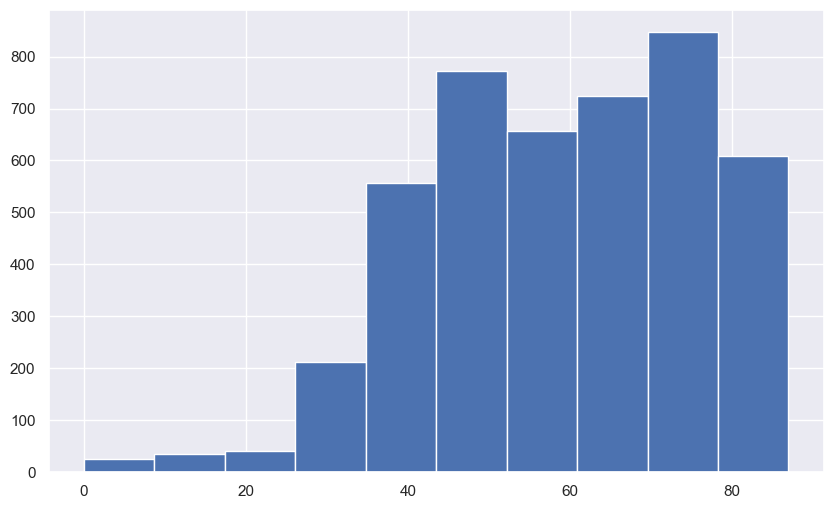

In [16]:
# Exploracion previa
demograficos['DONOR_AGE'].hist(figsize=(10, 6))

print('DONOR_GENDER: \n', demograficos['DONOR_GENDER'].value_counts())

print('\n HOME_OWNER: \n', demograficos['HOME_OWNER'].value_counts())

Posibles variables de estudio:
* `CLUSTER_CODE`, `SES`, `WEALTH_RATING` y `INCOME_GROUP` son variables de agrupación socio-económica. Podemos estudiar relación entre ellas y eliminar variables redundantes o utilizarlas para imputar missing en caso en que haya entre ellas

* `MEDIAN_HOUSEHOLD_INCOME`, `PER_CAPITA_INCOME`, `MEDIAN_HOME_VALUE`. son variable de ingresos por capita/zona.

* `URBANICIRY` clasificación del domiciolio individual.

* `PCT_ ` son variables que miden el porcentaje de militares/veteranos en el vecindario.

In [17]:
demograficos['SES'].unique()

array(['1', '4', '2', '?', '3'], dtype=object)

In [18]:
# Podemos tratar de imputar la variable con lo que conocemos
df[df['SES']=='?'][['SES','MEDIAN_HOUSEHOLD_INCOME','PER_CAPTITA_INCOME']].isna().any()

SES                        False
MEDIAN_HOUSEHOLD_INCOME    False
PER_CAPTITA_INCOME         False
dtype: bool

In [19]:
# Convertimos '?' a pd.NA 
demograficos['SES'] = pd.to_numeric(demograficos['SES'], errors='coerce')

# Convertimos 'SES' a float64
demograficos['SES'] = demograficos['SES'].astype(float)

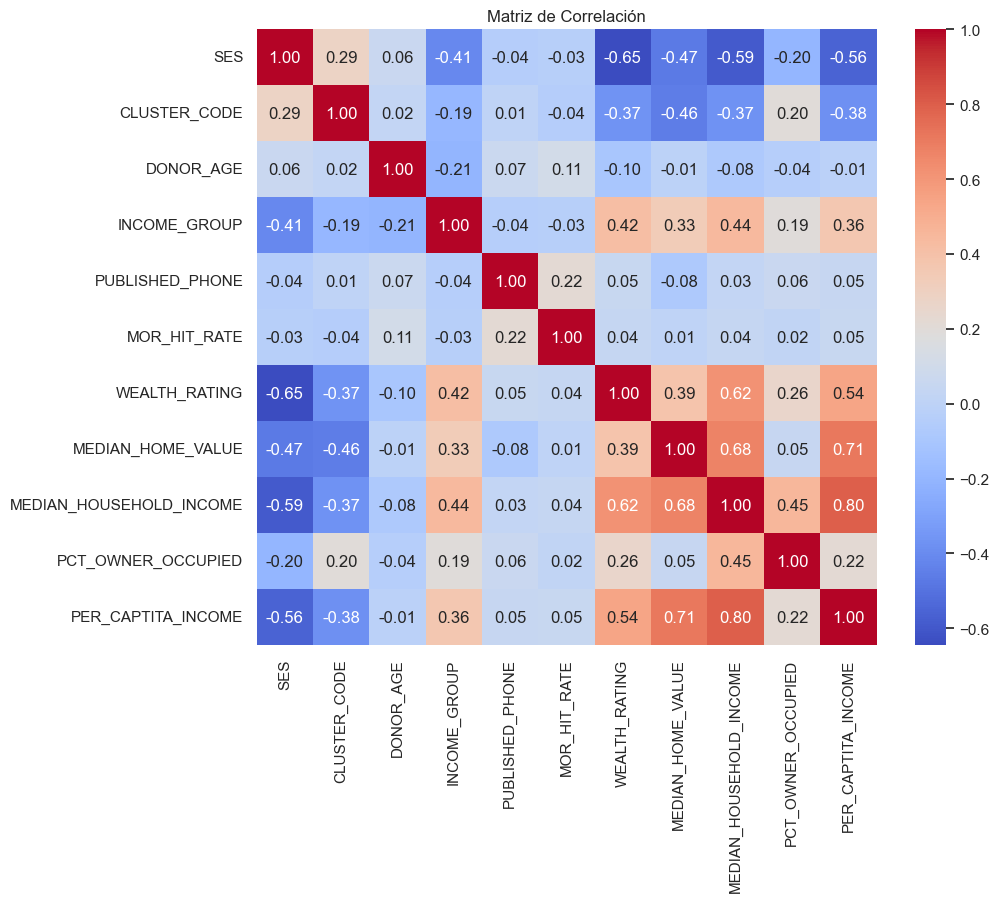

In [20]:
# Calcular la matriz de correlación
correlation_matrix = demograficos.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Como `SES`está muy correlada con `INCOME_GROUP` y `WEALTH_RATING`que presenta un alto porcentaje de valores missing, eliminamos estas variables del modelo. Además, también eliminamos`CLUSTER_CODE` pues se trata de otra variable de agrupación socio-economica que presenta missing cuando `SES` presenta missing. 

In [21]:
# Mas variables a eliminar
eliminar.append('CLUSTER_CODE')
eliminar.append('WEALTH_RATING')
eliminar.append('INCOME_GROUP')

* Estudiamos los valores missing para imputar la variable `SES`

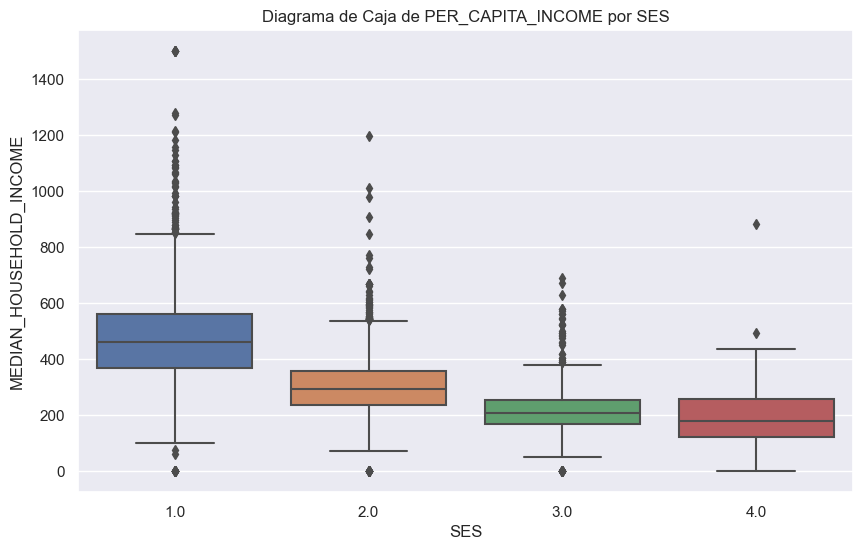

In [22]:
# Diagrama de caja
plt.figure(figsize=(10, 6))
sns.boxplot(x='SES', y='MEDIAN_HOUSEHOLD_INCOME', data=demograficos)
plt.title('Diagrama de Caja de PER_CAPITA_INCOME por SES')
plt.show()

In [23]:
medianas_por_ses = demograficos.groupby('SES')['MEDIAN_HOUSEHOLD_INCOME'].median()
print('Medianas: \n', medianas_por_ses)

income_ses = demograficos.groupby('SES')['PER_CAPTITA_INCOME'].mean()
print('\n Medias income: \n', income_ses)

Medianas: 
 SES
1.0    461.0
2.0    293.0
3.0    208.0
4.0    180.0
Name: MEDIAN_HOUSEHOLD_INCOME, dtype: float64

 Medias income: 
 SES
1.0    23064.919346
2.0    13441.175105
3.0    10204.868110
4.0     9001.897436
Name: PER_CAPTITA_INCOME, dtype: float64


In [24]:
limses1 = medianas_por_ses[1]
limses2 = medianas_por_ses[2]
limses3 = medianas_por_ses[3]
limses4 = medianas_por_ses[4]

demograficos.loc[demograficos['SES'].isna() & (demograficos['MEDIAN_HOUSEHOLD_INCOME'] < limses4), 'SES'] = 4
demograficos.loc[demograficos['SES'].isna() & (demograficos['MEDIAN_HOUSEHOLD_INCOME'] >= limses4) & (demograficos['MEDIAN_HOUSEHOLD_INCOME'] < limses3), 'SES'] = 4
demograficos.loc[demograficos['SES'].isna() & (demograficos['MEDIAN_HOUSEHOLD_INCOME'] >= limses3) & (demograficos['MEDIAN_HOUSEHOLD_INCOME'] < limses2), 'SES'] = 3
demograficos.loc[demograficos['SES'].isna() & (demograficos['MEDIAN_HOUSEHOLD_INCOME'] >= limses2) & (demograficos['MEDIAN_HOUSEHOLD_INCOME'] < limses1), 'SES'] = 2
demograficos.loc[demograficos['SES'].isna() & (demograficos['MEDIAN_HOUSEHOLD_INCOME'] >= limses1), 'SES'] = 1

# Verificar que ya no haya valores faltantes en SES
print(demograficos['SES'].isnull().sum())

0


In [25]:
# Cambiamos por la variable imputda
df.drop('SES', axis = 1, inplace = True)
df['SES'] = demograficos['SES']

* `PER_CAPITA_INCOME`

Para los valores que son 0, asignamos el valor medio de `PER_CAPITA_INCOME` agrupando por `SES`.

Text(0, 0.5, 'Ingreso Mediano del Hogar')

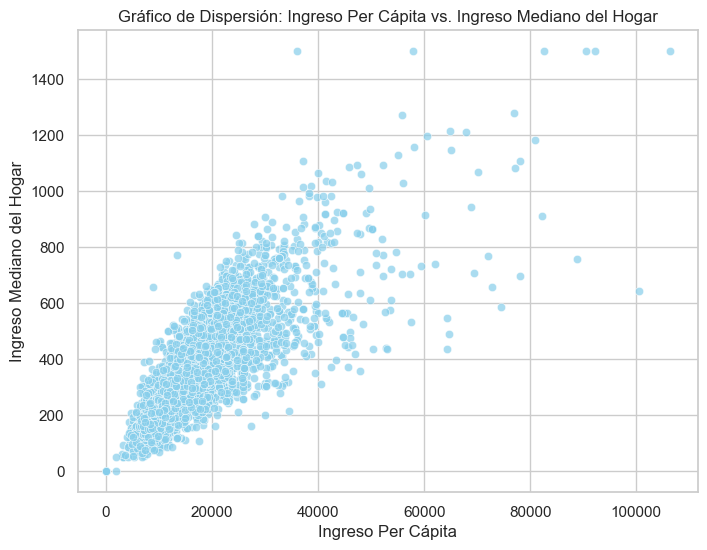

In [27]:
# Configuración de estilo
sns.set_style('whitegrid')

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['PER_CAPTITA_INCOME'], y=df['MEDIAN_HOUSEHOLD_INCOME'], color='skyblue', alpha=0.7)
plt.title('Gráfico de Dispersión: Ingreso Per Cápita vs. Ingreso Mediano del Hogar')
plt.xlabel('Ingreso Per Cápita')
plt.ylabel('Ingreso Mediano del Hogar')

In [28]:
# Calcular las medias agrupadas por SES
mediana_por_ses = demograficos.groupby('SES')['MEDIAN_HOUSEHOLD_INCOME'].median()
mediana_por_ses

SES
1.0    463.5
2.0    295.0
3.0    210.0
4.0    176.0
Name: MEDIAN_HOUSEHOLD_INCOME, dtype: float64

In [29]:
# Calcular las medias agrupadas por SES
media_por_ses = demograficos.groupby('SES')['PER_CAPTITA_INCOME'].mean()

# Crear un subDataFrame con los valores de PER_CAPTITA_INCOME igual a 0
sub_df = demograficos[demograficos['PER_CAPTITA_INCOME'] == 0]

# Asignar las medias agrupadas por SES a los valores de PER_CAPTITA_INCOME igual a 0
for ses, media in media_por_ses.items():
    sub_df.loc[sub_df['SES'] == ses, 'PER_CAPTITA_INCOME'] = media

# Actualizar el DataFrame original con los cambios
demograficos.update(sub_df)

# Verificar que los valores se hayan actualizado correctamente
print(demograficos[demograficos['PER_CAPTITA_INCOME'] == 0])

Empty DataFrame
Columns: [SES, CLUSTER_CODE, HOME_OWNER, DONOR_GENDER, DONOR_AGE, INCOME_GROUP, PUBLISHED_PHONE, OVERLAY_SOURCE, MOR_HIT_RATE, WEALTH_RATING, MEDIAN_HOME_VALUE, MEDIAN_HOUSEHOLD_INCOME, PCT_OWNER_OCCUPIED, PER_CAPTITA_INCOME]
Index: []


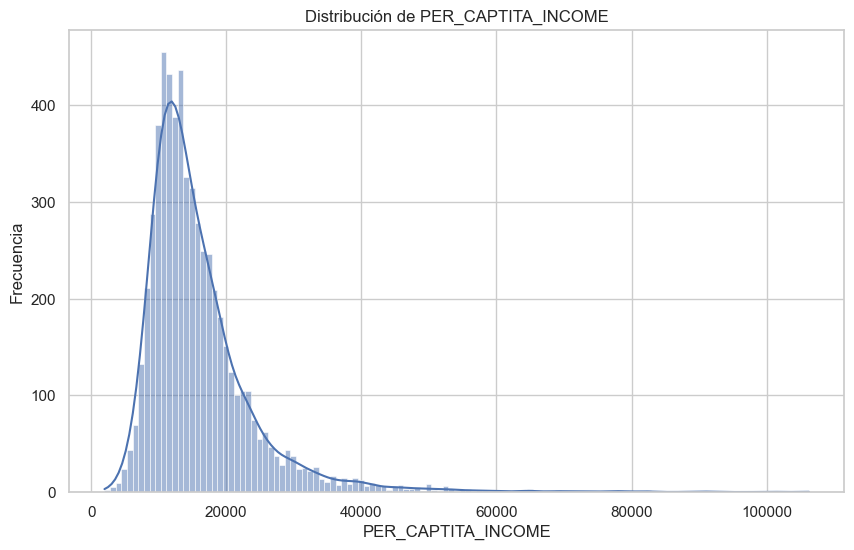

In [30]:
# Histograma de la variable PER_CAPTITA_INCOME
plt.figure(figsize=(10, 6))
sns.histplot(demograficos['PER_CAPTITA_INCOME'], kde=True)
plt.title('Distribución de PER_CAPTITA_INCOME')
plt.xlabel('PER_CAPTITA_INCOME')
plt.ylabel('Frecuencia')
plt.show()

In [31]:
# Cambiamos por la variable imputda
df.drop('PER_CAPTITA_INCOME', axis = 1, inplace = True)
df['PER_CAPTITA_INCOME'] = demograficos['PER_CAPTITA_INCOME']

In [32]:
# Mas variables a eliminar
eliminar.append('MEDIAN_HOUSEHOLD_INCOME')
eliminar.append('MEDIAN_HOME_VALUE')

* `DONOR_AGE`

In [33]:
print(df['DONOR_AGE'].describe())

# Imputamos por O - asi podemos saber luego con un arbol si la clase
# missing es relevante
df['DONOR_AGE'] = df['DONOR_AGE'].fillna(0)

count    4476.000000
mean       59.088695
std        16.640610
min         0.000000
25%        47.000000
50%        59.500000
75%        73.000000
max        87.000000
Name: DONOR_AGE, dtype: float64


De esta sección nos quedamos con las variables: `SES`, `CLUSTER_CODE`, `PER_CAPTITA_INCOME`, `PCT_OWNER_OCCUPIED` imputadas

**4. DATOS CENSALES**

In [34]:
censales = df[['URBANICITY', 'PCT_MALE_MILITARY', 'PCT_MALE_VETERANS', 'PCT_VIETNAM_VETERANS',
       'PCT_WWII_VETERANS']]

In [35]:
censales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5950 entries, 0 to 5949
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   URBANICITY            5950 non-null   object
 1   PCT_MALE_MILITARY     5950 non-null   int64 
 2   PCT_MALE_VETERANS     5950 non-null   int64 
 3   PCT_VIETNAM_VETERANS  5950 non-null   int64 
 4   PCT_WWII_VETERANS     5950 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 232.6+ KB


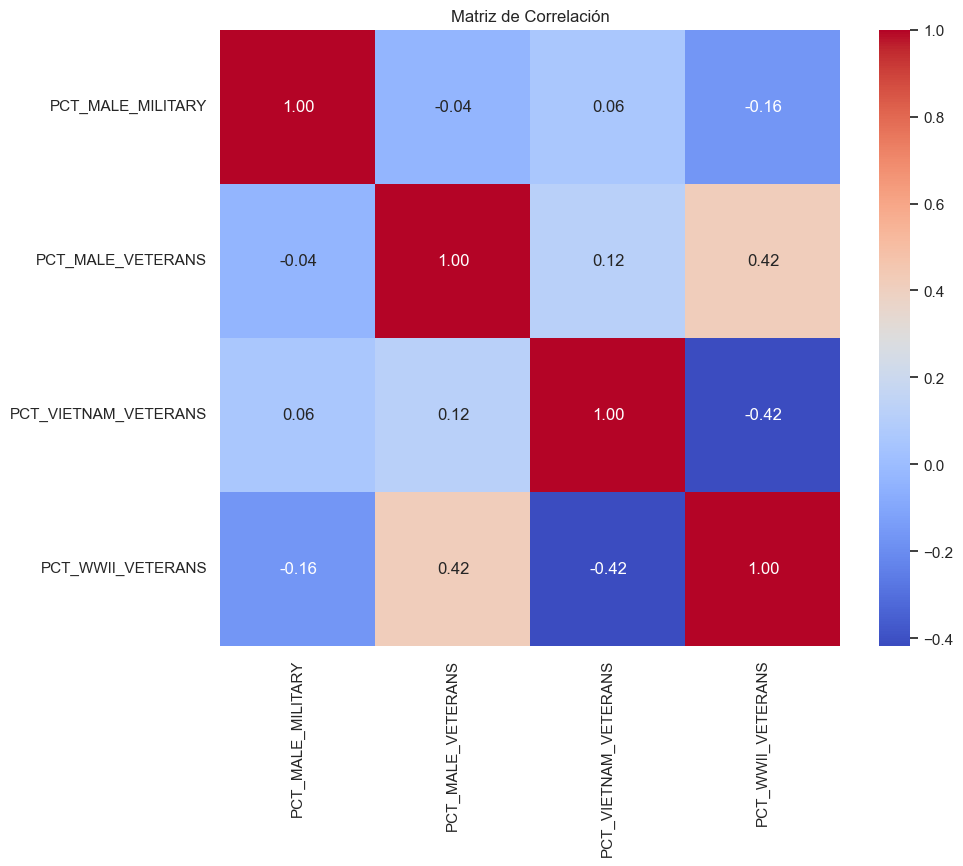

In [36]:
# Calcular la matriz de correlación
correlation_matrix = censales.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Parece que la variable `PCT_WWII_VETERANS` esta correlada con el resto. Nos quedamos con ella y con `PCT_MALE_MILITARY`

In [37]:
# Mas variables a eliminar
eliminar.append('PCT_MALE_VETERANS')
eliminar.append('PCT_VIETNAM_VETERANS')

**5. TRANSACCIONES**

In [39]:
transacciones = df[['CARD_PROM_12', 'NUMBER_PROM_12','FREQUENCY_STATUS_97NK',
                  'MONTHS_SINCE_LAST_PROM_RESP','LAST_GIFT_AMT',
                  'RECENT_RESPONSE_PROP',
       'RECENT_AVG_GIFT_AMT', 'RECENT_CARD_RESPONSE_PROP',
       'RECENT_AVG_CARD_GIFT_AMT', 'RECENT_RESPONSE_COUNT',
       'RECENT_CARD_RESPONSE_COUNT',
                   'LIFETIME_CARD_PROM', 'LIFETIME_PROM', 'LIFETIME_GIFT_AMOUNT',
       'LIFETIME_GIFT_COUNT', 'LIFETIME_AVG_GIFT_AMT', 'LIFETIME_GIFT_RANGE',
       'LIFETIME_MAX_GIFT_AMT', 'LIFETIME_MIN_GIFT_AMT',
     'MONTHS_SINCE_LAST_GIFT',
       'MONTHS_SINCE_FIRST_GIFT', 'FILE_AVG_GIFT', 'FILE_CARD_GIFT'
                  ]]

In [40]:
transacciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5950 entries, 0 to 5949
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CARD_PROM_12                 5950 non-null   int64  
 1   NUMBER_PROM_12               5950 non-null   int64  
 2   FREQUENCY_STATUS_97NK        5950 non-null   int64  
 3   MONTHS_SINCE_LAST_PROM_RESP  5874 non-null   float64
 4   LAST_GIFT_AMT                5950 non-null   float64
 5   RECENT_RESPONSE_PROP         5950 non-null   float64
 6   RECENT_AVG_GIFT_AMT          5950 non-null   float64
 7   RECENT_CARD_RESPONSE_PROP    5950 non-null   float64
 8   RECENT_AVG_CARD_GIFT_AMT     5950 non-null   float64
 9   RECENT_RESPONSE_COUNT        5950 non-null   int64  
 10  RECENT_CARD_RESPONSE_COUNT   5950 non-null   int64  
 11  LIFETIME_CARD_PROM           5950 non-null   int64  
 12  LIFETIME_PROM                5950 non-null   int64  
 13  LIFETIME_GIFT_AMOU

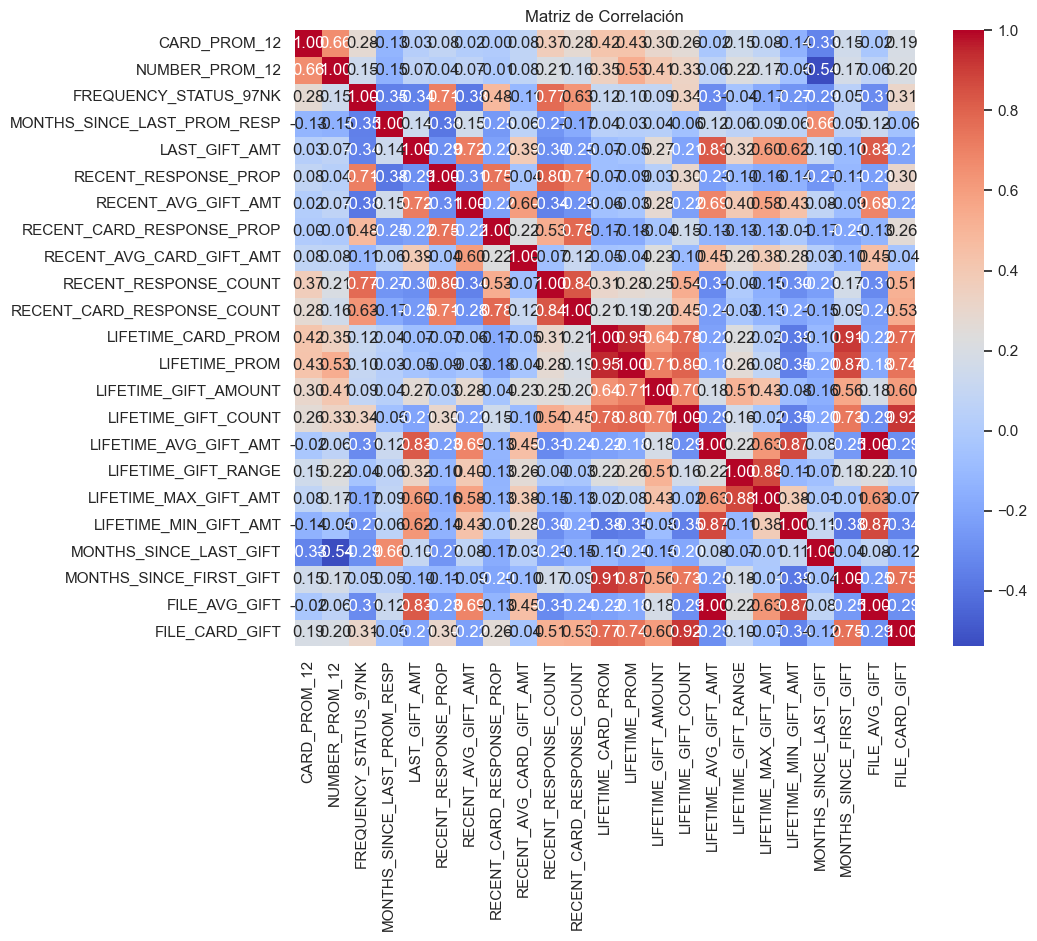

In [41]:
# Calcular la matriz de correlación
correlation_matrix = transacciones.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

De esta sección, sólo `MONTHS_SINCE_LAST_PROM_RESP` presenta valores missing, los imputamos.

In [42]:
print(df[['MONTHS_SINCE_LAST_PROM_RESP', 'MONTHS_SINCE_LAST_GIFT']])

# Imputar 'MONTHS_SINCE_LAST_PROM_RESP' con 'MONTHS_SINCE_LAST_GIFT'
df['MONTHS_SINCE_LAST_PROM_RESP'].fillna(df['MONTHS_SINCE_LAST_GIFT'], inplace=True)

      MONTHS_SINCE_LAST_PROM_RESP  MONTHS_SINCE_LAST_GIFT
0                            19.0                      19
1                            17.0                      17
2                            17.0                      17
3                            21.0                       6
4                            22.0                      18
...                           ...                     ...
5945                         24.0                      24
5946                         18.0                      18
5947                         21.0                      21
5948                         20.0                      20
5949                         21.0                      21

[5950 rows x 2 columns]


De esta sección nos quedamos con:
`CARD_PROM_12`, `FREQUENCY_STATUS_97NK`, `RECENT_CARD_RESPONSE_COUNT`,`LIFETIME_AVG_GIFT_AMT` `MONTHS_BTW_GIFT` y `FILE_CARD_GIFT`

In [43]:
MONTHS_BTW_GIFT = df['MONTHS_SINCE_FIRST_GIFT'] - df['MONTHS_SINCE_LAST_GIFT']
df['MONTHS_BTW_GIFT'] = MONTHS_BTW_GIFT 
                                                      
# Mas variables a eliminar
eliminar.append('NUMBER_PROM_12')
eliminar.append('MONTHS_SINCE_LAST_PROM_RESP')
eliminar.append('LAST_GIFT_AMT')
eliminar.append('RECENT_RESPONSE_PROP')
eliminar.append('RECENT_AVG_GIFT_AMT')
eliminar.append('RECENT_CARD_RESPONSE_PROP')
eliminar.append('RECENT_AVG_CARD_GIFT_AMT')
eliminar.append('RECENT_RESPONSE_COUNT')
eliminar.append('RECENT_RESPONSE_COUNT')
eliminar.append('LIFETIME_CARD_PROM')
eliminar.append('LIFETIME_PROM')
eliminar.append('LIFETIME_GIFT_AMOUNT')
eliminar.append('LIFETIME_GIFT_COUNT')
eliminar.append('LIFETIME_GIFT_RANGE') 
eliminar.append('LIFETIME_MAX_GIFT_AMT')
eliminar.append('LIFETIME_MIN_GIFT_AMT')
eliminar.append('MONTHS_SINCE_LAST_GIFT')
eliminar.append('MONTHS_SINCE_FIRST_GIFT')
eliminar.append('FILE_AVG_GIFT')                          

Eliminamos las variables

In [44]:
# Eliminar las columnas del DataFrame df
df.drop(eliminar, axis=1, inplace=True)

In [45]:
# Comprobamos que no haya varibales con valores missing
df.isna().any()

CONTROL_NUMBER_N              False
MONTHS_SINCE_ORIGIN           False
DONOR_AGE                     False
IN_HOUSE                      False
URBANICITY                    False
HOME_OWNER                    False
DONOR_GENDER                  False
PCT_OWNER_OCCUPIED            False
PCT_MALE_MILITARY             False
PCT_WWII_VETERANS             False
PEP_STAR                      False
RECENT_STAR_STATUS            False
RECENCY_STATUS_96NK           False
FREQUENCY_STATUS_97NK         False
RECENT_CARD_RESPONSE_COUNT    False
LIFETIME_AVG_GIFT_AMT         False
CARD_PROM_12                  False
FILE_CARD_GIFT                False
SES                           False
PER_CAPTITA_INCOME            False
MONTHS_BTW_GIFT               False
dtype: bool

In [50]:
# Matriz de observaciones
X_profe = df.drop(['CONTROL_NUMBER_N'], axis=1) 
X_profe['IN_HOUSE'] = X_profe['IN_HOUSE'].astype(str)
X_profe['SES'] = X_profe['SES'].astype(str)
X_profe['PEP_STAR'] = X_profe['PEP_STAR'].astype(str)
X_profe = pd.get_dummies(X_profe)

# Variable target
control = df['CONTROL_NUMBER_N'].copy()

## Particionamiento final

In [52]:
# Librerias
import os

# Carpeta con datos
if not os.path.exists('Datos'):
    os.makedirs('Datos')
    
# Se guardan los datos
X_profe.to_csv('Datos/X_profe.csv', index=False)
control.to_csv('Datos/control.csv', index=False)